# README

This takes the data generated from gen_npProximity_data.py and converts it into graphs. This experiment is focusing on three curves. One of the curves is fixated at TI = 0 and the other two are variable around the null points. We are interested to know how the selection of the null point relevant TI values change the MSE observed.

# Libraries

In [12]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools
import os
from matplotlib.ticker import MultipleLocator

# Initialization

In [13]:
cwd_temp = os.getcwd()
base_file = 'Stabilization'
cwd_full = cwd_temp.split(base_file, 1)[0]
print(cwd_full)

exp_file = 'npProximity_Data'
exp_date = '25Sep23'

param_oi = 2

assert(param_oi >= 0 and param_oi < 6)

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

c:\co\NIA\


In [14]:
with open(f'{cwd_full}\{base_file}\CustomObjFunc\{exp_file}\hprParameter_{exp_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    SNR_value = dict["SNR_value"]
    TI1_region = dict['TI1_region']
    TI2_region = dict['TI2_region']
    true_params = dict["true_params"]
    nTE = dict["nTE"]
    dTE = dict["dTE"]
    var_reps = dict["var_reps"]
    BIC_eval_iter = dict['BIC_eval_iter']
    multi_start = dict['multi_start']
    handle.close()

T11, T12, c1, c2, T21, T22 = true_params

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

TI1_region = np.floor(TI1star)+TI1_region
TI2_region = np.floor(TI2star)+TI2_region

In [15]:
def to_readable(file):
    df = pd.read_pickle(file)
    ALL_TI = np.stack(df["TI_combo"].values) #shape: (voxel)
    ALL_MSE = np.stack(df["MSE"].values) #shape: (voxel)
    ALL_VAR = np.stack(df["var"].values) #shape: (voxel)

    ALL_BIAS = df["bias"].values #shape: (voxel, lambda, popt)
    ALL_BIC = df["BIC"].values #shape: (voxel, lambda)
    
    return ALL_TI, ALL_MSE, ALL_VAR, ALL_BIAS, ALL_BIC

def BIC_opt1(RSS, TE_array, p_list, sigma):

    BIC = 1/len(TE_array) * (RSS + np.log(len(TE_array))*len(p_list)*(sigma)**2)

    return BIC

def int_lengh_opt1(R0, num_TE, diff_TE, SNR):
    return ((2*np.log(num_TE)-2)*diff_TE/(R0*SNR**2))**(1/2)

def int_lengh_AIC(R0, diff_TE, SNR):
    return (2*diff_TE/(R0*SNR**2))**(1/2)

In [16]:
def prepare_data(p_oi):

    MSE_ordered = np.zeros((len(TI2_region), len(TI1_region), 3))
    var_ordered = np.zeros((len(TI2_region), len(TI1_region), 3))
    bias_ordered = np.zeros((len(TI2_region), len(TI1_region), 3))
    BIC_ordered = np.zeros((len(TI2_region), len(TI1_region), 3))

    data_name = f"{cwd_full}\{base_file}\CustomObjFunc\{exp_file}\{'n'}pProx_{exp_date}.pkl"

    print("Retrieving data for " + data_name)
    TI_combo, MSE, VAR, BIAS, BIC = to_readable(data_name)

    for index in range(TI_combo.shape[0]):

        TI1_part = TI_combo[index][0]
        TI2_part = TI_combo[index][1]

        TI1_index = np.where(TI1_region==TI1_part)[0][0]
        TI2_index = np.where(TI2_region==TI2_part)[0][0]

        BIC_ordered[TI2_index, TI1_index,:] = BIC[index]/var_reps
        MSE_ordered[TI2_index, TI1_index,:] = MSE[index][:,p_oi]
        var_ordered[TI2_index, TI1_index,:] = VAR[index][:,p_oi]
        bias_ordered[TI2_index, TI1_index,:] = BIAS[index][:,p_oi]

    return MSE_ordered, var_ordered, bias_ordered, BIC_ordered

In [17]:
MSE, var, bias, BIC = prepare_data(param_oi)

Retrieving data for c:\co\NIA\\Stabilization\CustomObjFunc\npProximity_Data\npProx_25Sep23.pkl


In [18]:
interval_length_TI1 = int_lengh_opt1(R0_coeff_TI1, nTE, dTE, SNR_value)

low_TI1 = TI1star - interval_length_TI1
high_TI1 = TI1star + interval_length_TI1

interval_length_TI2 = int_lengh_opt1(R0_coeff_TI2, nTE, dTE, SNR_value)

low_TI2 = TI2star - interval_length_TI2
high_TI2 = TI2star + interval_length_TI2

In [19]:
interval_length_AIC_TI1 = int_lengh_AIC(R0_coeff_TI1, dTE, SNR_value)

low_AIC_TI1 = TI1star - interval_length_AIC_TI1
high_AIC_TI1 = TI1star + interval_length_AIC_TI1

interval_length_AIC_TI2 = int_lengh_AIC(R0_coeff_TI2, dTE, SNR_value)

low_AIC_TI2 = TI2star - interval_length_AIC_TI2
high_AIC_TI2 = TI2star + interval_length_AIC_TI2

In [20]:
MSE_max = np.max(MSE)
var_max = np.max(var)
biasSq_max = np.max(bias**2)

num_steps = 30
MSE_bin_array = np.arange(0, 1.05*MSE_max, MSE_max/num_steps)
var_byTI_array_bin_array = np.arange(0, 1.05*var_max, var_max/num_steps)
biasSq_bin_array = np.arange(0, 1.05*biasSq_max, biasSq_max/num_steps)

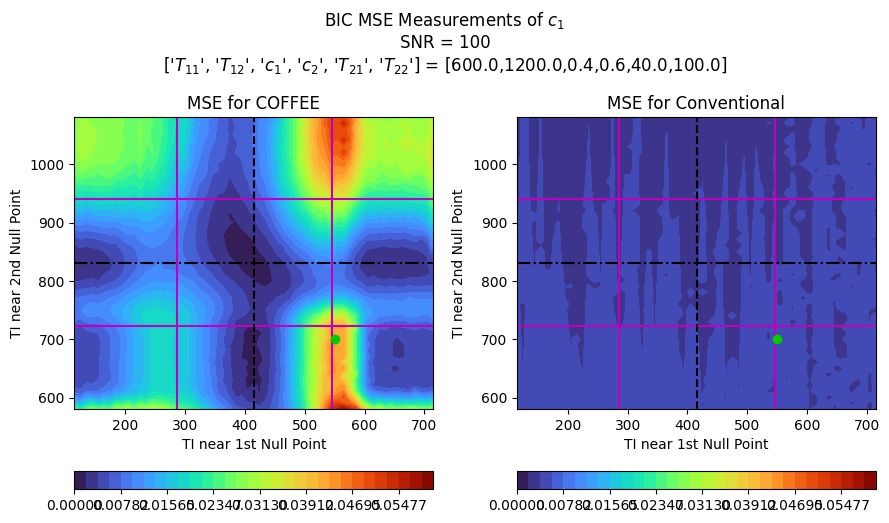

In [21]:
mTI_np1, mTI_np2 = np.meshgrid(TI1_region, TI2_region)
ordering = ["COFFEE", "Conventional", "Curve Fit"]

fig, ax = plt.subplots(1, 2, figsize=(9,5.5), tight_layout=True)
fig.suptitle(f"BIC MSE Measurements of {ParamTitle_6p[param_oi]}\nSNR = {SNR_value}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

for iter in range(2):

    cp = ax[iter].contourf(mTI_np1, mTI_np2, MSE[:,:,iter], levels = MSE_bin_array, cmap = 'turbo')
    cb = fig.colorbar(cp, ax = ax[iter], location = 'bottom')
    # cb.locator = MultipleLocator(10**(np.floor(np.log10(MSE_max))-1))
    # cb.update_ticks()

    ax[iter].axhline(y = TI2star, color = 'k', ls = '-.', label = 'Null Point 2')
    ax[iter].axhline(y = low_TI2, color = 'm')
    ax[iter].axhline(y = high_TI2, color = 'm')
    ax[iter].axvline(x = TI1star, color = 'k', ls = '--', label = 'Null Point 1')
    ax[iter].axvline(x = low_TI1, color = 'm')
    ax[iter].axvline(x = high_TI1, color = 'm')
    # ax[iter].plot(mTI_np1, mTI_np2, ls = '', marker = 'o', color = 'g')

    ax[iter].set_xlabel('TI near 1st Null Point')
    ax[iter].set_ylabel('TI near 2nd Null Point')
    ax[iter].set_title(f'MSE for {ordering[iter]}')

point_oi_x = 550
point_oi_y = 700
ax[0].plot(point_oi_x, point_oi_y, marker = 'o', ls = '', color = [0,0.8,0])
ax[1].plot(point_oi_x, point_oi_y, marker = 'o', ls = '', color = [0,0.8,0])

Text(0.75, -0.05, 'Conventional\nSuperior')

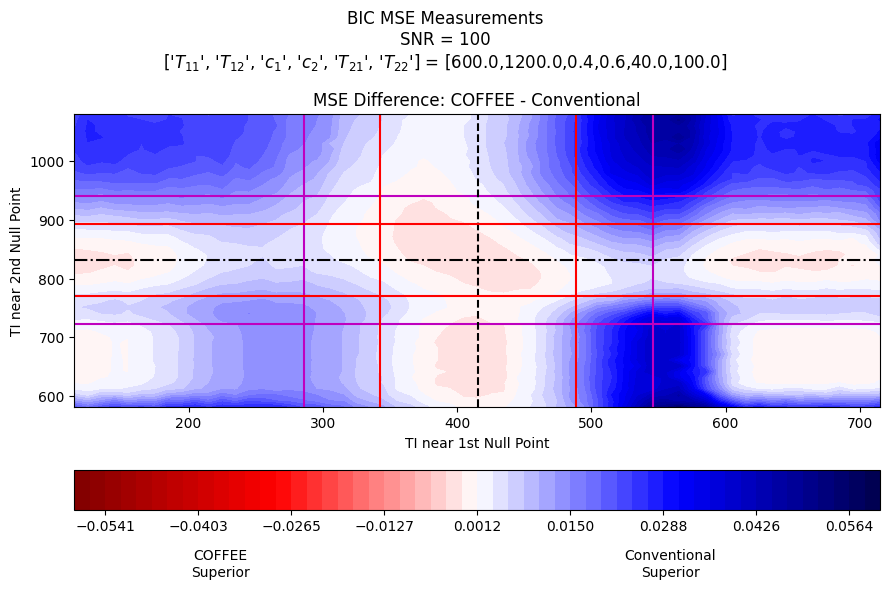

In [22]:
mTI_np1, mTI_np2 = np.meshgrid(TI1_region, TI2_region)
ordering = ["COFFEE", "Conventional", "Curve Fit"]

num_steps = 51
MSE_diff_array = np.arange(-1*MSE_max, 1.05*MSE_max, 2*MSE_max/num_steps)

fig, ax = plt.subplots(1, 1, figsize=(9,5.5), tight_layout=True)
fig.suptitle(f"BIC MSE Measurements\nSNR = {SNR_value}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")


cp = ax.contourf(mTI_np1, mTI_np2, MSE[:,:,0] - MSE[:,:,1], levels = MSE_diff_array, cmap = 'seismic_r')
cb = fig.colorbar(cp, ax = ax, location = 'bottom')
# cb.locator = MultipleLocator(10**(np.floor(np.log(MSE_max))))
# cb.update_ticks()

ax.axhline(y = TI2star, color = 'k', ls = '-.', label = 'Null Point 2')
ax.axhline(y = low_TI2, color = 'm')
ax.axhline(y = high_TI2, color = 'm')
ax.axvline(x = TI1star, color = 'k', ls = '--', label = 'Null Point 1')
ax.axvline(x = low_TI1, color = 'm')
ax.axvline(x = high_TI1, color = 'm')

ax.axhline(y = low_AIC_TI2, color = 'r')
ax.axhline(y = high_AIC_TI2, color = 'r')
ax.axvline(x = low_AIC_TI1, color = 'r')
ax.axvline(x = high_AIC_TI1, color = 'r')
# ax[iter].plot(mTI_np1, mTI_np2, ls = '', marker = 'o', color = 'g')

ax.set_xlabel('TI near 1st Null Point')
ax.set_ylabel('TI near 2nd Null Point')
ax.set_title(f'MSE Difference: COFFEE - Conventional')
fig.text(0.25, -0.05,"COFFEE\nSuperior", ha='center')
fig.text(0.75, -0.05,"Conventional\nSuperior", ha='center')

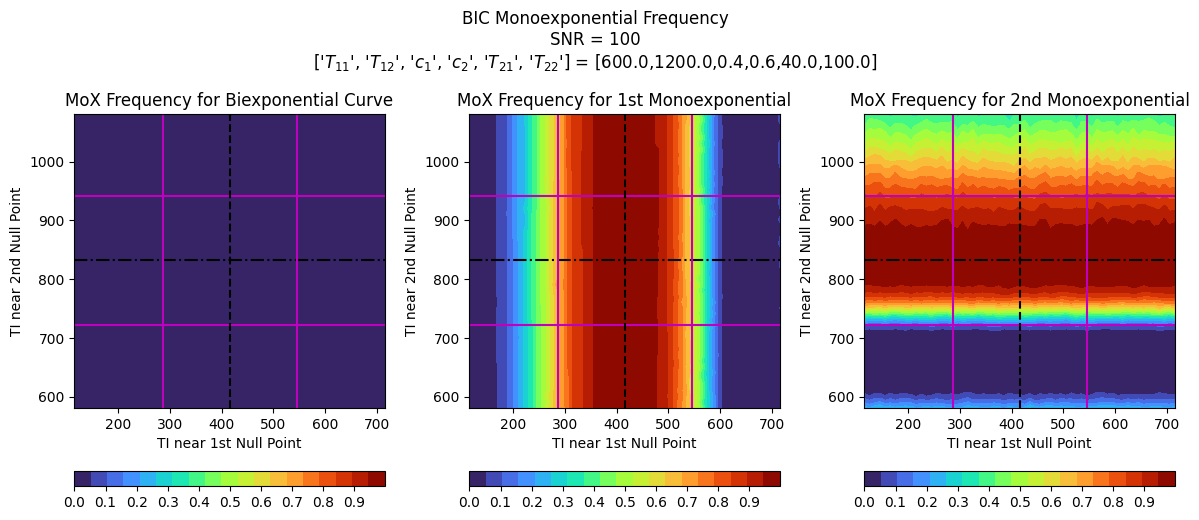

In [23]:
mTI_np1, mTI_np2 = np.meshgrid(TI1_region, TI2_region)
ordering = ["Biexponential Curve", "1st Monoexponential", "2nd Monoexponential"]

fig, ax = plt.subplots(1, 3, figsize=(12,5.5), tight_layout=True)
fig.suptitle(f"BIC Monoexponential Frequency\nSNR = {SNR_value}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

num_steps = 20
freq_array = np.arange(0, 1.00, 1.05/num_steps)

for iter in range(3):

    cp = ax[iter].contourf(mTI_np1, mTI_np2, BIC[:,:,iter], levels = freq_array, cmap = 'turbo')
    cb = fig.colorbar(cp, ax = ax[iter], location = 'bottom')
    cb.locator = MultipleLocator(0.1)
    cb.update_ticks()

    ax[iter].axhline(y = TI2star, color = 'k', ls = '-.', label = 'Null Point 2')
    ax[iter].axhline(y = low_TI2, color = 'm')
    ax[iter].axhline(y = high_TI2, color = 'm')
    ax[iter].axvline(x = TI1star, color = 'k', ls = '--', label = 'Null Point 1')
    ax[iter].axvline(x = low_TI1, color = 'm')
    ax[iter].axvline(x = high_TI1, color = 'm')
    # ax[iter].plot(mTI_np1, mTI_np2, ls = '', marker = 'o', color = 'g')

    ax[iter].set_xlabel('TI near 1st Null Point')
    ax[iter].set_ylabel('TI near 2nd Null Point')
    ax[iter].set_title(f'MoX Frequency for {ordering[iter]}')